# **Classifying CIFAR10 images using CNN in PyTorch**


In [2]:
## Importing modules ##

# Import PyTorch
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms

# for file system
import os

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# for model evaluation
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import numpy as np

# for randimization
import random

# type
from typing import List , Dict , Tuple

In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# transforms object to use in data augmentation

mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]

data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness = 0.1,contrast = 0.1,saturation = 0.1),
    transforms.RandomAdjustSharpness(sharpness_factor = 2,p = 0.2),
    transforms.ToTensor() ,
    transforms.Normalize(mean, std),
    transforms.RandomErasing(p=0.75,scale=(0.02, 0.1),value=1.0, inplace=False)
])

In [5]:
# Setup training data

train_data = datasets.CIFAR10(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=data_transform, # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data

test_data = datasets.CIFAR10(
    root="data",
    train=False, # get test data
    download=True,
    transform=data_transform
)

In [6]:
#see classes

class_names = train_data.classes

class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

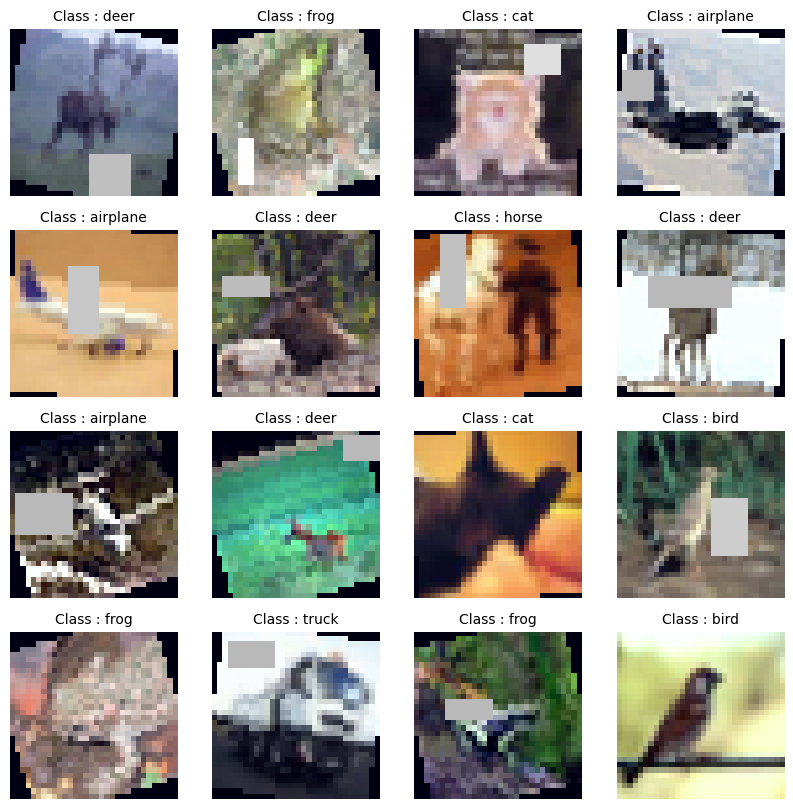

In [ ]:

rand_idx = random.sample(range(len(train_data)),k=16)

plt.figure(figsize=(10,10))

for i , idx in enumerate(rand_idx):

  img , label = train_data[idx]

  img = (img - img.min()) / (img.max() - img.min())

  img_class = class_names[label]

  plt.subplot(4,4,i+1)
  plt.imshow(img.permute(1,2,0))
  plt.title(f"Class : {img_class}",fontsize=10)
  plt.axis(False)


In [8]:
#load data into dataloader

NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 800

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)



In [9]:
# train loop function
def train_step(model:nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:nn.Module,
               optimizer:torch.optim.Optimizer,
               scheduler:torch.optim.lr_scheduler = None,
               grad_clip:float=None):

  model.train()

  train_loss , train_acc = 0 , 0

  for batch , (X,y) in enumerate(dataloader):

    X , y = X.to(device) , y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred,y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()

    if grad_clip:
      nn.utils.clip_grad_value_(model.parameters(), grad_clip)

    optimizer.step()
    y_pred_class = torch.argmax(y_pred,dim=1)
    train_acc += (y_pred_class == y).sum().item() / len(y)

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  if scheduler is not None:
    scheduler.step(train_loss)


  return train_loss , train_acc

In [10]:
# test loop function
def test_step(model:nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn:nn.Module):

  model.eval()

  test_loss , test_acc = 0 , 0

  with torch.inference_mode():
    for batch , (X,y) in enumerate(dataloader):
      X , y = X.to(device) , y.to(device)
      test_pred_logits = model(X)
      loss = loss_fn(test_pred_logits,y)
      test_loss += loss.item()
      test_pred_labels = torch.argmax(test_pred_logits,dim=1)
      test_acc += (test_pred_labels == y).sum().item() / len(y)

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  return test_loss , test_acc

In [11]:
#Creating a train() function to combine train_step() and test_step()

from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          scheduler:torch.optim.lr_scheduler,
          grad_clip:float=None,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 10):

    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           scheduler=scheduler,
                                           grad_clip=grad_clip)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)


        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )


        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

/home/dakshesh/Desktop/Projects/cifar10/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
# function to plot loss & accuracy curve

def plot_loss_curves(results: Dict[str, List[float]]):


    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.grid()
    plt.legend()


    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.grid()
    plt.legend()

# **(tiny)VGG Model**

The VGG model, short for Visual Geometry Group, is a deep convolutional neural network architecture proposed by researchers from the University of Oxford. It gained popularity for its simplicity and effectiveness in image recognition tasks, particularly in the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) competition.The VGG architecture consists of multiple convolutional layers followed by max-pooling layers, with fully connected layers at the end for classification. The key characteristics of the VGG architecture are:

* **Convolutional Layers:** The convolutional layers use small 3x3 filters with a stride of 1 and zero-padding to maintain the spatial resolution of the input feature maps. The depth of the feature maps increases as we go deeper into the network.
* **Max Pooling Layers:** After each set of convolutional layers, max-pooling layers with a 2x2 window and a stride of 2 are applied to downsample the feature maps and reduce their spatial dimensions.
* **Fully Connected Layers:** The final layers of the VGG architecture consist of fully connected layers, also known as dense layers, which take the flattened feature maps from the convolutional layers as input and produce the final output logits for classification.

The TinyVGG class defines a simple convolutional neural network (CNN) architecture inspired by the VGG architecture, but with fewer layers and parameters.


In [13]:
#build a model

class TinyVGG(nn.Module):
  def __init__(self, input_shape: int, output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=32,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=32,
                  out_channels=32,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=32,
                  out_channels=64,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=64,
                  out_channels=64,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=64*8*8,out_features=2048),
        nn.ReLU(),
        nn.Dropout(p=0.5), #add dropout layer to decrease overfitting
        nn.Linear(in_features=2048,out_features=1024),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(in_features=1024,out_features=output_shape)
    )



  def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [14]:
# create model object
try:
  import torchinfo
except:
  %pip install torchinfo
  import torchinfo

from torchinfo import summary

model_0 = TinyVGG(input_shape=3,
                  output_shape=len(class_names)).to(device)

#[batch_size,color_channels,width,height]
summary(model_0, input_size=[1, 3, 32, 32])

Note: you may need to restart the kernel to use updated packages.


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 32, 16, 16]           --
│    └─Conv2d: 2-1                       [1, 32, 32, 32]           896
│    └─ReLU: 2-2                         [1, 32, 32, 32]           --
│    └─Conv2d: 2-3                       [1, 32, 32, 32]           9,248
│    └─ReLU: 2-4                         [1, 32, 32, 32]           --
│    └─MaxPool2d: 2-5                    [1, 32, 16, 16]           --
├─Sequential: 1-2                        [1, 64, 8, 8]             --
│    └─Conv2d: 2-6                       [1, 64, 16, 16]           18,496
│    └─ReLU: 2-7                         [1, 64, 16, 16]           --
│    └─Conv2d: 2-8                       [1, 64, 16, 16]           36,928
│    └─ReLU: 2-9                         [1, 64, 16, 16]           --
│    └─MaxPool2d: 2-10                   [1, 64, 8, 8]             --
├─S

# **Model Training**

## Hyperparameters Explanation

### 1. Epoch

- `NUM_EPOCHS` specifies the number of epochs, i.e., the number of times the entire training dataset is passed through the neural network during training. Choosing a suitable number of epochs ensures that the model has sufficient opportunity to learn from the data without overfitting or underfitting.

### 2. Learning rate

- `learning_rate` determines the step size at which the optimizer updates the model's parameters during training. A higher learning rate allows for faster convergence but may risk overshooting the optimal solution, while a lower learning rate may lead to slower convergence but better stability. The value of 0.002 is chosen empirically based on experimentation and learning rate schedules.

### 3. Weight decay

- `weight_decay`, also known as L2 regularization, penalizes large weights in the model's parameters to prevent overfitting. It helps in controlling model complexity and improving generalization performance. The value of 15e-5 is chosen to strike a balance between regularization strength and model performance based on empirical observations.

### 4. Gradient clipping

- Gradient clipping (`grad_clip`) is a technique used to mitigate the exploding gradient problem during training by capping the gradients to a predefined threshold. This helps stabilize the training process and prevent numerical instability.

### 5. Loss Function and Optimizer

- `loss_fn = nn.CrossEntropyLoss()` The cross-entropy loss function is commonly used for classification tasks with multiple classes. It measures the discrepancy between the predicted class probabilities and the true labels.
  
- `optimizer = torch.optim.Adam(...)` Adam optimizer is a popular choice for training neural networks due to its adaptive learning rate capabilities and momentum. The learning rate and weight decay parameters specified here determine the optimization behavior.

### 6. Learning Rate Scheduler

- `scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(...)` Learning rate schedulers dynamically adjust the learning rate during training based on certain criteria. The ReduceLROnPlateau scheduler reduces the learning rate when a monitored metric (e.g., validation loss) stops improving, helping the model converge more effectively.


In [16]:
# Let's train
NUM_EPOCHS = 30
learning_rate = 0.001
weight_decay = 15e-5
grad_clip = 0.001

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_0.parameters(),lr=learning_rate,weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.3,patience=3,threshold=0.09)


from timeit import default_timer as timer
start_time = timer()


model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        grad_clip=grad_clip,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)


end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  3%|▎         | 1/30 [00:06<03:16,  6.77s/it]

Epoch: 1 | train_loss: 1.8858 | train_acc: 0.3118 | test_loss: 1.6088 | test_acc: 0.4180


  7%|▋         | 2/30 [00:13<03:03,  6.55s/it]

Epoch: 2 | train_loss: 1.5893 | train_acc: 0.4232 | test_loss: 1.4927 | test_acc: 0.4592


 10%|█         | 3/30 [00:19<02:56,  6.54s/it]

Epoch: 3 | train_loss: 1.4719 | train_acc: 0.4696 | test_loss: 1.3625 | test_acc: 0.5045


 13%|█▎        | 4/30 [00:26<02:49,  6.52s/it]

Epoch: 4 | train_loss: 1.3762 | train_acc: 0.5037 | test_loss: 1.2809 | test_acc: 0.5379


 17%|█▋        | 5/30 [00:32<02:42,  6.48s/it]

Epoch: 5 | train_loss: 1.3006 | train_acc: 0.5336 | test_loss: 1.2450 | test_acc: 0.5520


 20%|██        | 6/30 [00:39<02:35,  6.48s/it]

Epoch: 6 | train_loss: 1.2502 | train_acc: 0.5512 | test_loss: 1.1655 | test_acc: 0.5746


 23%|██▎       | 7/30 [00:45<02:29,  6.49s/it]

Epoch: 7 | train_loss: 1.2124 | train_acc: 0.5666 | test_loss: 1.1328 | test_acc: 0.5969


 27%|██▋       | 8/30 [00:52<02:22,  6.47s/it]

Epoch: 8 | train_loss: 1.1833 | train_acc: 0.5781 | test_loss: 1.0996 | test_acc: 0.6112


 30%|███       | 9/30 [00:58<02:15,  6.45s/it]

Epoch: 9 | train_loss: 1.1365 | train_acc: 0.5946 | test_loss: 1.0577 | test_acc: 0.6238


 33%|███▎      | 10/30 [01:04<02:09,  6.47s/it]

Epoch: 10 | train_loss: 1.1083 | train_acc: 0.6059 | test_loss: 1.0414 | test_acc: 0.6257


 37%|███▋      | 11/30 [01:11<02:03,  6.48s/it]

Epoch: 11 | train_loss: 1.0792 | train_acc: 0.6175 | test_loss: 1.0404 | test_acc: 0.6288


 40%|████      | 12/30 [01:17<01:56,  6.47s/it]

Epoch: 12 | train_loss: 1.0531 | train_acc: 0.6263 | test_loss: 0.9979 | test_acc: 0.6467


 43%|████▎     | 13/30 [01:24<01:50,  6.48s/it]

Epoch: 13 | train_loss: 1.0260 | train_acc: 0.6395 | test_loss: 0.9598 | test_acc: 0.6619


 47%|████▋     | 14/30 [01:30<01:43,  6.46s/it]

Epoch: 14 | train_loss: 0.9894 | train_acc: 0.6492 | test_loss: 0.9256 | test_acc: 0.6776


 50%|█████     | 15/30 [01:37<01:36,  6.47s/it]

Epoch: 15 | train_loss: 0.9844 | train_acc: 0.6557 | test_loss: 0.9464 | test_acc: 0.6672


 53%|█████▎    | 16/30 [01:43<01:30,  6.48s/it]

Epoch: 16 | train_loss: 0.9669 | train_acc: 0.6585 | test_loss: 0.9342 | test_acc: 0.6752


 57%|█████▋    | 17/30 [01:50<01:24,  6.48s/it]

Epoch: 17 | train_loss: 0.9505 | train_acc: 0.6632 | test_loss: 0.9177 | test_acc: 0.6760


 60%|██████    | 18/30 [01:56<01:17,  6.47s/it]

Epoch: 18 | train_loss: 0.8685 | train_acc: 0.6950 | test_loss: 0.8366 | test_acc: 0.7058


 63%|██████▎   | 19/30 [02:03<01:11,  6.47s/it]

Epoch: 19 | train_loss: 0.8271 | train_acc: 0.7079 | test_loss: 0.8050 | test_acc: 0.7159


 67%|██████▋   | 20/30 [02:09<01:04,  6.47s/it]

Epoch: 20 | train_loss: 0.8166 | train_acc: 0.7140 | test_loss: 0.8108 | test_acc: 0.7177


 70%|███████   | 21/30 [02:16<00:58,  6.48s/it]

Epoch: 21 | train_loss: 0.7990 | train_acc: 0.7205 | test_loss: 0.7946 | test_acc: 0.7162


 73%|███████▎  | 22/30 [02:22<00:52,  6.50s/it]

Epoch: 22 | train_loss: 0.7918 | train_acc: 0.7203 | test_loss: 0.8029 | test_acc: 0.7126


 77%|███████▋  | 23/30 [02:29<00:45,  6.51s/it]

Epoch: 23 | train_loss: 0.7658 | train_acc: 0.7307 | test_loss: 0.7785 | test_acc: 0.7228


 80%|████████  | 24/30 [02:35<00:39,  6.50s/it]

Epoch: 24 | train_loss: 0.7507 | train_acc: 0.7344 | test_loss: 0.7787 | test_acc: 0.7253


 83%|████████▎ | 25/30 [02:42<00:32,  6.50s/it]

Epoch: 25 | train_loss: 0.7449 | train_acc: 0.7363 | test_loss: 0.7620 | test_acc: 0.7338


 87%|████████▋ | 26/30 [02:48<00:26,  6.50s/it]

Epoch: 26 | train_loss: 0.7367 | train_acc: 0.7398 | test_loss: 0.7575 | test_acc: 0.7282


 90%|█████████ | 27/30 [02:55<00:19,  6.50s/it]

Epoch: 27 | train_loss: 0.7311 | train_acc: 0.7421 | test_loss: 0.7517 | test_acc: 0.7363


 93%|█████████▎| 28/30 [03:01<00:12,  6.50s/it]

Epoch: 28 | train_loss: 0.7211 | train_acc: 0.7460 | test_loss: 0.7531 | test_acc: 0.7326


 97%|█████████▋| 29/30 [03:08<00:06,  6.50s/it]

Epoch: 29 | train_loss: 0.7209 | train_acc: 0.7479 | test_loss: 0.7414 | test_acc: 0.7404


100%|██████████| 30/30 [03:14<00:00,  6.49s/it]

Epoch: 30 | train_loss: 0.7216 | train_acc: 0.7457 | test_loss: 0.7458 | test_acc: 0.7372
Total training time: 194.685 seconds


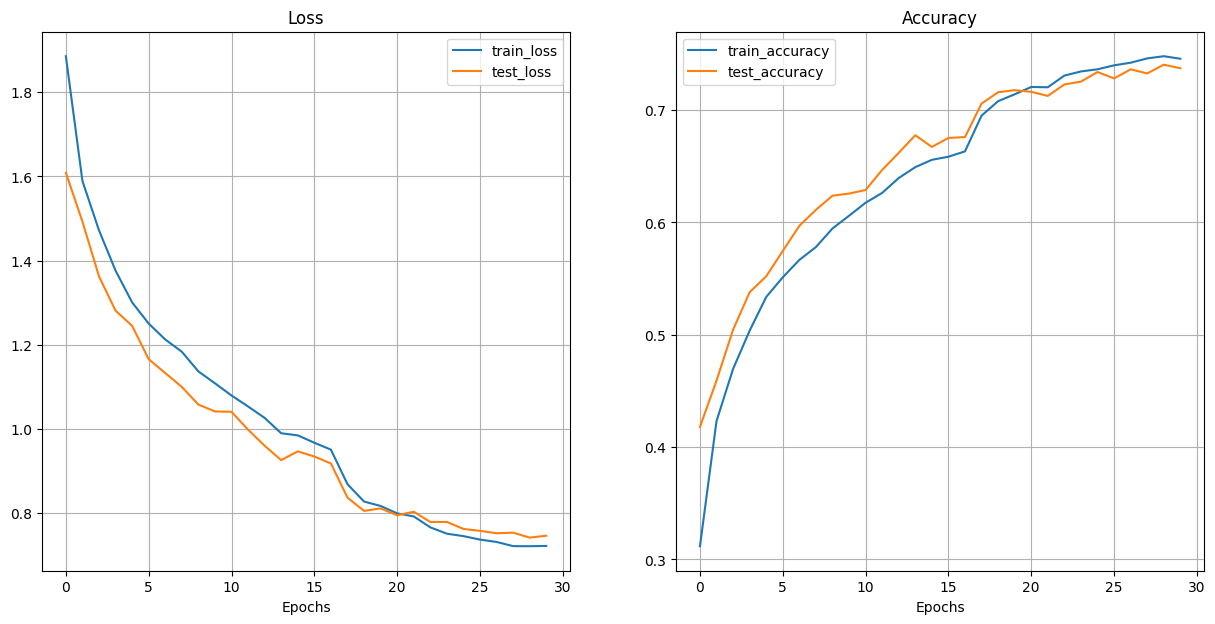

In [17]:
plot_loss_curves(model_0_results)

In [18]:
# create Resnet model class

class ResNet9(nn.Module):
    def conv_block(self,in_channels, out_channels, pool=False):
      layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)]
      if pool: layers.append(nn.MaxPool2d(2))
      return nn.Sequential(*layers)

    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = self.conv_block(in_channels, 64)
        self.conv2 = self.conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(self.conv_block(128, 128), self.conv_block(128, 128))

        self.conv3 = self.conv_block(128, 256, pool=True)
        self.conv4 = self.conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(self.conv_block(512, 512), self.conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [19]:
# create model object
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary

model_2 = ResNet9(3,10).to(device)

#[batch_size,color_channels,width,height]
summary(model_2, input_size=[1, 3, 32, 32])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet9                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 32, 32]           128
│    └─ReLU: 2-3                         [1, 64, 32, 32]           --
├─Sequential: 1-2                        [1, 128, 16, 16]          --
│    └─Conv2d: 2-4                       [1, 128, 32, 32]          73,856
│    └─BatchNorm2d: 2-5                  [1, 128, 32, 32]          256
│    └─ReLU: 2-6                         [1, 128, 32, 32]          --
│    └─MaxPool2d: 2-7                    [1, 128, 16, 16]          --
├─Sequential: 1-3                        [1, 128, 16, 16]          --
│    └─Sequential: 2-8                   [1, 128, 16, 16]          --
│    │    └─Conv2d: 3-1                  [1, 128, 16, 16]          147,584
│

In [21]:
# Let's train
NUM_EPOCHS = 30
learning_rate = 0.001
weight_decay = 35e-5
grad_clip = 1e-4

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_2.parameters(),lr=learning_rate,weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.3,patience=3,threshold=0.09)


from timeit import default_timer as timer
start_time = timer()


model_2_results = train(model=model_2,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        grad_clip=grad_clip,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)


end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  3%|▎         | 1/30 [00:25<12:29, 25.83s/it]

Epoch: 1 | train_loss: 1.5872 | train_acc: 0.4496 | test_loss: 1.1983 | test_acc: 0.5676


  7%|▋         | 2/30 [00:51<12:04, 25.89s/it]

Epoch: 2 | train_loss: 1.0395 | train_acc: 0.6314 | test_loss: 1.1690 | test_acc: 0.5898


 10%|█         | 3/30 [01:17<11:37, 25.84s/it]

Epoch: 3 | train_loss: 0.8731 | train_acc: 0.6946 | test_loss: 0.9757 | test_acc: 0.6584


 13%|█▎        | 4/30 [01:43<11:12, 25.86s/it]

Epoch: 4 | train_loss: 0.7764 | train_acc: 0.7292 | test_loss: 0.9691 | test_acc: 0.6569


 17%|█▋        | 5/30 [02:09<10:48, 25.94s/it]

Epoch: 5 | train_loss: 0.7345 | train_acc: 0.7462 | test_loss: 0.9263 | test_acc: 0.6796


 20%|██        | 6/30 [02:35<10:22, 25.92s/it]

Epoch: 6 | train_loss: 0.6810 | train_acc: 0.7670 | test_loss: 1.1786 | test_acc: 0.5832


 23%|██▎       | 7/30 [03:01<09:55, 25.90s/it]

Epoch: 7 | train_loss: 0.6510 | train_acc: 0.7779 | test_loss: 0.9437 | test_acc: 0.6707


 27%|██▋       | 8/30 [03:27<09:29, 25.89s/it]

Epoch: 8 | train_loss: 0.6255 | train_acc: 0.7879 | test_loss: 0.9889 | test_acc: 0.6621


 30%|███       | 9/30 [03:53<09:03, 25.89s/it]

Epoch: 9 | train_loss: 0.6021 | train_acc: 0.7949 | test_loss: 0.9094 | test_acc: 0.6911


 33%|███▎      | 10/30 [04:18<08:37, 25.86s/it]

Epoch: 10 | train_loss: 0.5955 | train_acc: 0.7975 | test_loss: 1.1659 | test_acc: 0.6139


 37%|███▋      | 11/30 [04:44<08:11, 25.87s/it]

Epoch: 11 | train_loss: 0.5878 | train_acc: 0.8016 | test_loss: 1.0166 | test_acc: 0.6400


 40%|████      | 12/30 [05:10<07:45, 25.87s/it]

Epoch: 12 | train_loss: 0.5777 | train_acc: 0.8049 | test_loss: 0.7874 | test_acc: 0.7248


 43%|████▎     | 13/30 [05:36<07:19, 25.85s/it]

Epoch: 13 | train_loss: 0.5700 | train_acc: 0.8065 | test_loss: 1.0516 | test_acc: 0.6331


 47%|████▋     | 14/30 [06:02<06:53, 25.86s/it]

Epoch: 14 | train_loss: 0.4428 | train_acc: 0.8528 | test_loss: 0.5672 | test_acc: 0.8051


 50%|█████     | 15/30 [06:28<06:27, 25.86s/it]

Epoch: 15 | train_loss: 0.3913 | train_acc: 0.8683 | test_loss: 0.6724 | test_acc: 0.7724


 53%|█████▎    | 16/30 [06:53<06:01, 25.84s/it]

Epoch: 16 | train_loss: 0.3708 | train_acc: 0.8777 | test_loss: 0.6038 | test_acc: 0.7902


 57%|█████▋    | 17/30 [07:19<05:36, 25.85s/it]

Epoch: 17 | train_loss: 0.3540 | train_acc: 0.8845 | test_loss: 0.5373 | test_acc: 0.8141


 60%|██████    | 18/30 [07:45<05:10, 25.85s/it]

Epoch: 18 | train_loss: 0.3441 | train_acc: 0.8857 | test_loss: 0.5620 | test_acc: 0.8039


 63%|██████▎   | 19/30 [08:11<04:44, 25.87s/it]

Epoch: 19 | train_loss: 0.3369 | train_acc: 0.8900 | test_loss: 0.5687 | test_acc: 0.8061


 67%|██████▋   | 20/30 [08:37<04:18, 25.87s/it]

Epoch: 20 | train_loss: 0.3281 | train_acc: 0.8912 | test_loss: 0.5810 | test_acc: 0.8019


 70%|███████   | 21/30 [09:03<03:52, 25.89s/it]

Epoch: 21 | train_loss: 0.3244 | train_acc: 0.8932 | test_loss: 0.5395 | test_acc: 0.8194


 73%|███████▎  | 22/30 [09:29<03:26, 25.86s/it]

Epoch: 22 | train_loss: 0.2566 | train_acc: 0.9185 | test_loss: 0.4057 | test_acc: 0.8622


 77%|███████▋  | 23/30 [09:55<03:01, 25.87s/it]

Epoch: 23 | train_loss: 0.2269 | train_acc: 0.9287 | test_loss: 0.3859 | test_acc: 0.8695


 80%|████████  | 24/30 [10:20<02:35, 25.89s/it]

Epoch: 24 | train_loss: 0.2165 | train_acc: 0.9318 | test_loss: 0.3876 | test_acc: 0.8661


 83%|████████▎ | 25/30 [10:46<02:09, 25.85s/it]

Epoch: 25 | train_loss: 0.2090 | train_acc: 0.9346 | test_loss: 0.3792 | test_acc: 0.8716


 87%|████████▋ | 26/30 [11:12<01:43, 25.84s/it]

Epoch: 26 | train_loss: 0.1988 | train_acc: 0.9377 | test_loss: 0.3710 | test_acc: 0.8735


 90%|█████████ | 27/30 [11:38<01:17, 25.86s/it]

Epoch: 27 | train_loss: 0.1909 | train_acc: 0.9409 | test_loss: 0.3908 | test_acc: 0.8663


 93%|█████████▎| 28/30 [12:04<00:51, 25.86s/it]

Epoch: 28 | train_loss: 0.1828 | train_acc: 0.9444 | test_loss: 0.3881 | test_acc: 0.8674


 97%|█████████▋| 29/30 [12:30<00:25, 25.88s/it]

Epoch: 29 | train_loss: 0.1804 | train_acc: 0.9451 | test_loss: 0.3789 | test_acc: 0.8698


100%|██████████| 30/30 [12:56<00:00, 25.87s/it]

Epoch: 30 | train_loss: 0.1714 | train_acc: 0.9479 | test_loss: 0.4386 | test_acc: 0.8536
Total training time: 776.150 seconds


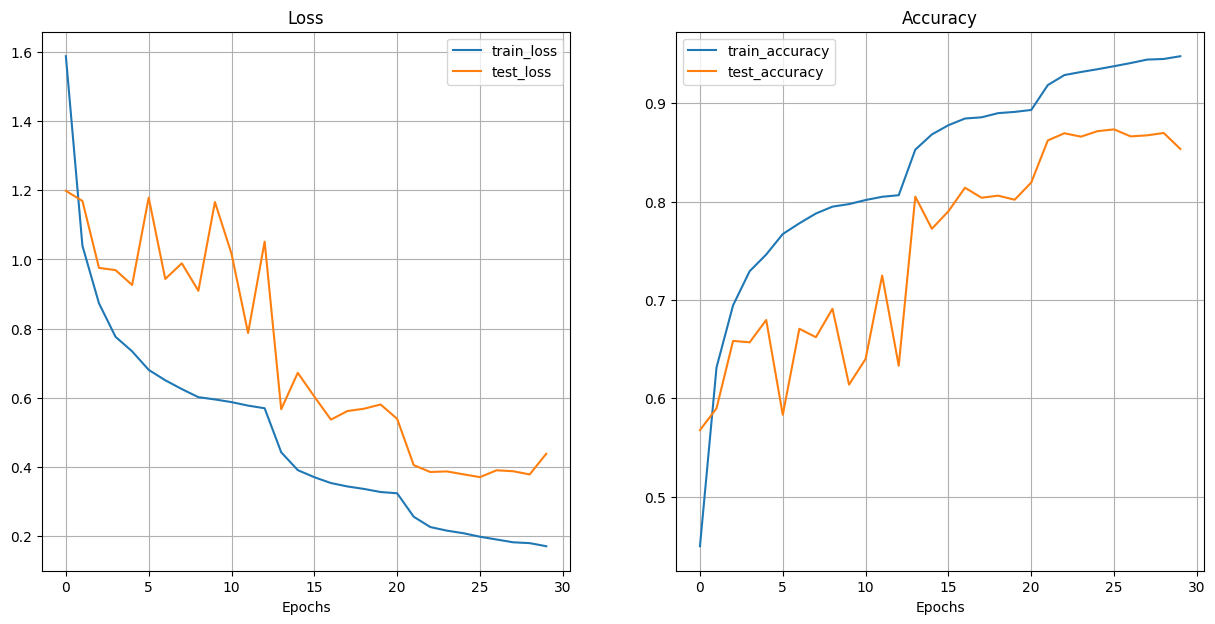

In [22]:
plot_loss_curves(model_2_results)

# **Model Evaluation**

Resnet Model appears to be better than TinyVGG Model due to its higher accuracy, faster convergence speed, and slightly better generalization performance. However, both results show an instability in loss and accuracy, which is a result from small batch size. The smaller batch size increase stochasticity in the optimization process,which can help the model escape local minima but introduce more noise.

So let's train Resnet model more, before we use it for prediction.

In [23]:
# more training iterations

NUM_EPOCHS = 30

from timeit import default_timer as timer
start_time = timer()


model_2_results_exten = train(model=model_2,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        grad_clip=grad_clip,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)


end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  3%|▎         | 1/30 [00:25<12:27, 25.79s/it]

Epoch: 1 | train_loss: 0.1692 | train_acc: 0.9487 | test_loss: 0.3719 | test_acc: 0.8750


  7%|▋         | 2/30 [00:51<12:03, 25.82s/it]

Epoch: 2 | train_loss: 0.1636 | train_acc: 0.9513 | test_loss: 0.3566 | test_acc: 0.8808


 10%|█         | 3/30 [01:17<11:38, 25.85s/it]

Epoch: 3 | train_loss: 0.1587 | train_acc: 0.9511 | test_loss: 0.3696 | test_acc: 0.8751


 13%|█▎        | 4/30 [01:43<11:12, 25.86s/it]

Epoch: 4 | train_loss: 0.1553 | train_acc: 0.9538 | test_loss: 0.4879 | test_acc: 0.8387


 17%|█▋        | 5/30 [02:09<10:46, 25.85s/it]

Epoch: 5 | train_loss: 0.1527 | train_acc: 0.9551 | test_loss: 0.4109 | test_acc: 0.8611


 20%|██        | 6/30 [02:35<10:20, 25.85s/it]

Epoch: 6 | train_loss: 0.1505 | train_acc: 0.9546 | test_loss: 0.3812 | test_acc: 0.8688


 23%|██▎       | 7/30 [03:00<09:54, 25.87s/it]

Epoch: 7 | train_loss: 0.1191 | train_acc: 0.9670 | test_loss: 0.3311 | test_acc: 0.8872


 27%|██▋       | 8/30 [03:26<09:28, 25.86s/it]

Epoch: 8 | train_loss: 0.1120 | train_acc: 0.9695 | test_loss: 0.3233 | test_acc: 0.8934


 30%|███       | 9/30 [03:52<09:02, 25.85s/it]

Epoch: 9 | train_loss: 0.1073 | train_acc: 0.9717 | test_loss: 0.3244 | test_acc: 0.8934


 33%|███▎      | 10/30 [04:18<08:37, 25.86s/it]

Epoch: 10 | train_loss: 0.1052 | train_acc: 0.9721 | test_loss: 0.3236 | test_acc: 0.8922


 37%|███▋      | 11/30 [04:44<08:11, 25.85s/it]

Epoch: 11 | train_loss: 0.1001 | train_acc: 0.9734 | test_loss: 0.3192 | test_acc: 0.8982


 40%|████      | 12/30 [05:10<07:45, 25.84s/it]

Epoch: 12 | train_loss: 0.0973 | train_acc: 0.9739 | test_loss: 0.3159 | test_acc: 0.8926


 43%|████▎     | 13/30 [05:35<07:18, 25.82s/it]

Epoch: 13 | train_loss: 0.0957 | train_acc: 0.9749 | test_loss: 0.3182 | test_acc: 0.8917


 47%|████▋     | 14/30 [06:01<06:52, 25.81s/it]

Epoch: 14 | train_loss: 0.0933 | train_acc: 0.9762 | test_loss: 0.3118 | test_acc: 0.8960


 50%|█████     | 15/30 [06:27<06:27, 25.80s/it]

Epoch: 15 | train_loss: 0.0911 | train_acc: 0.9765 | test_loss: 0.3248 | test_acc: 0.8934


 53%|█████▎    | 16/30 [06:53<06:01, 25.81s/it]

Epoch: 16 | train_loss: 0.0877 | train_acc: 0.9775 | test_loss: 0.3311 | test_acc: 0.8905


 57%|█████▋    | 17/30 [07:19<05:35, 25.83s/it]

Epoch: 17 | train_loss: 0.0868 | train_acc: 0.9775 | test_loss: 0.3283 | test_acc: 0.8895


 60%|██████    | 18/30 [07:45<05:09, 25.81s/it]

Epoch: 18 | train_loss: 0.0858 | train_acc: 0.9774 | test_loss: 0.3320 | test_acc: 0.8871


 63%|██████▎   | 19/30 [08:10<04:44, 25.82s/it]

Epoch: 19 | train_loss: 0.0845 | train_acc: 0.9787 | test_loss: 0.3269 | test_acc: 0.8916


 67%|██████▋   | 20/30 [08:36<04:18, 25.81s/it]

Epoch: 20 | train_loss: 0.0813 | train_acc: 0.9795 | test_loss: 0.3243 | test_acc: 0.8944


 70%|███████   | 21/30 [09:02<03:52, 25.83s/it]

Epoch: 21 | train_loss: 0.0740 | train_acc: 0.9824 | test_loss: 0.3111 | test_acc: 0.8979


 73%|███████▎  | 22/30 [09:28<03:26, 25.87s/it]

Epoch: 22 | train_loss: 0.0715 | train_acc: 0.9830 | test_loss: 0.3081 | test_acc: 0.8959


 77%|███████▋  | 23/30 [09:54<03:00, 25.85s/it]

Epoch: 23 | train_loss: 0.0700 | train_acc: 0.9837 | test_loss: 0.3022 | test_acc: 0.8980


 80%|████████  | 24/30 [10:20<02:35, 25.87s/it]

Epoch: 24 | train_loss: 0.0685 | train_acc: 0.9847 | test_loss: 0.3031 | test_acc: 0.8976


 83%|████████▎ | 25/30 [10:46<02:09, 25.88s/it]

Epoch: 25 | train_loss: 0.0677 | train_acc: 0.9845 | test_loss: 0.3007 | test_acc: 0.9010


 87%|████████▋ | 26/30 [11:12<01:43, 25.89s/it]

Epoch: 26 | train_loss: 0.0664 | train_acc: 0.9844 | test_loss: 0.3088 | test_acc: 0.8961


 90%|█████████ | 27/30 [11:37<01:17, 25.87s/it]

Epoch: 27 | train_loss: 0.0671 | train_acc: 0.9848 | test_loss: 0.3012 | test_acc: 0.9004


 93%|█████████▎| 28/30 [12:03<00:51, 25.84s/it]

Epoch: 28 | train_loss: 0.0636 | train_acc: 0.9857 | test_loss: 0.3059 | test_acc: 0.9015


 97%|█████████▋| 29/30 [12:29<00:25, 25.86s/it]

Epoch: 29 | train_loss: 0.0648 | train_acc: 0.9845 | test_loss: 0.2945 | test_acc: 0.9026


100%|██████████| 30/30 [12:55<00:00, 25.85s/it]

Epoch: 30 | train_loss: 0.0638 | train_acc: 0.9858 | test_loss: 0.3012 | test_acc: 0.8986
Total training time: 775.360 seconds


In [24]:
# merge 2 results

for key in model_2_results.keys():
  model_2_results[key].extend(model_2_results_exten[key])

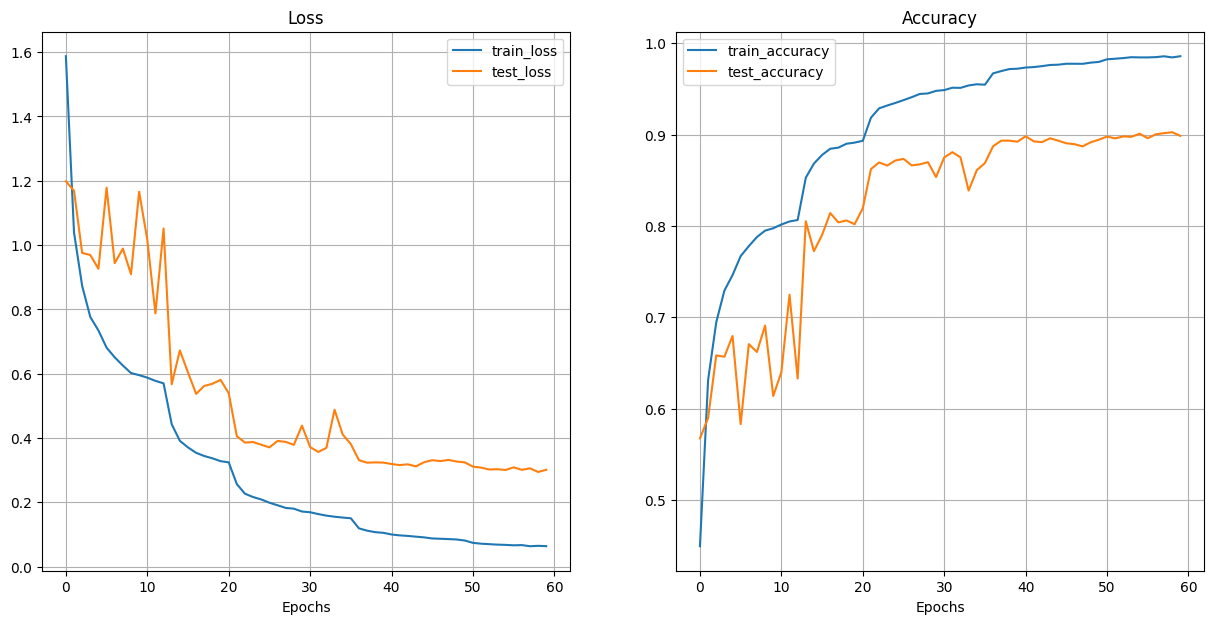

In [25]:
plot_loss_curves(model_2_results)

<Axes: >

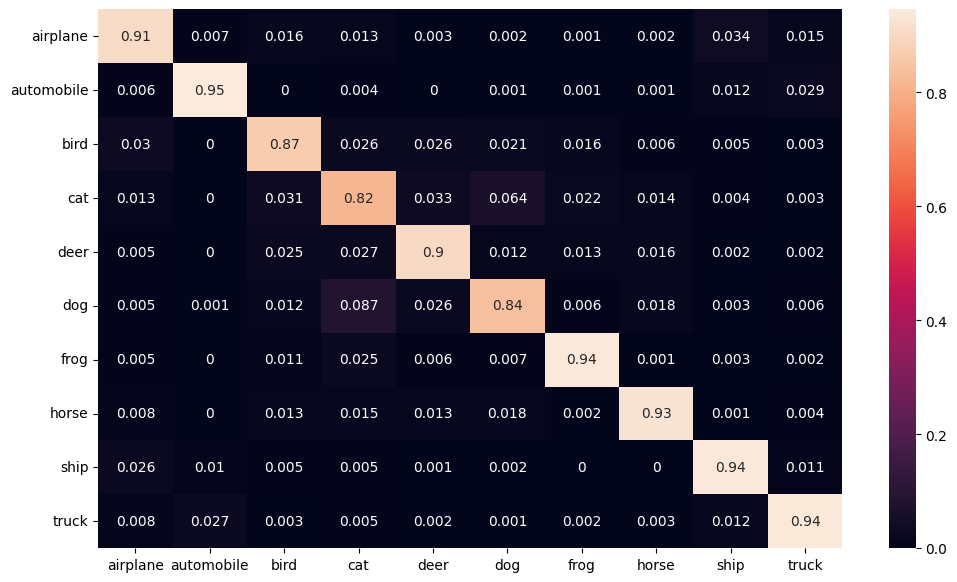

In [26]:
## Try predicting images with our model

y_pred = []
y_true = []

model_2.eval()

with torch.inference_mode():
  for X, y in DataLoader(dataset=test_data,batch_size=1,num_workers=NUM_WORKERS):
    X , y = X.to(device) , y.to(device)
    pred_logits = model_2(X)
    pred = pred_logits.argmax(dim=1).cpu().numpy()
    y_pred.extend(pred)
    true = y.cpu().numpy()
    y_true.extend(true)

cf_matrix = confusion_matrix(y_true,y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = class_names, columns = class_names)
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

The model performed preety well.We can achieve higher accuracy by using more complex model with more parameters. The model seems to confuse between dog and cat images.This phenomenon is often referred to as "class overlap" or "class ambiguity". That means that they share many visual features. These shared features can make it challenging for a machine learning model to differentiate between them, especially if the model is not provided with sufficient training examples that highlight these differences. The another factor is model complexity. If the model is relatively simple or lacks the capacity to capture intricate patterns in the data, it may fail to learn the subtle differences between classes.